# Baseline classifier for the Mendeley Liquid Based Cytology dataset

The idea is to get a baseline performance benchmark on this dataset without any "advanced" data processing and modeling techniques.

1. Select a pre-trained image classification model - I chose EfficientNet V2 Small
2. Don't perform any image pre-processing or augmentation except for those except for the resizing and normalisation required by the model
3. Replace the pre-trained model's classification layer
4. Fix the top layers of the pre-trained model, i.e. only train the last few feature layers as well as the new classification layer

## Download the data

In [ ]:
!mkdir data
!cd data && wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zddtpgzv63-2.zip
!cd data && unzip zddtpgzv63-2.zip

--2022-08-10 11:55:27--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zddtpgzv63-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.52.171
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.52.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212309361 (2.1G) [application/octet-stream]
Saving to: ‘zddtpgzv63-2.zip’

zddtpgzv63-2.zip    100%[===================>]   2.06G  27.6MB/s    in 77s     

2022-08-10 11:56:45 (27.2 MB/s) - ‘zddtpgzv63-2.zip’ saved [2212309361/2212309361]

Archive:  zddtpgzv63-2.zip
   creating: High squamous intra-epithelial lesion/
  inflating: High squamous intra-epithelial lesion/HSIL_8 (9).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_10 (8).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_2 (7).jpg

## Data processing

Tried to make this fairly generic so that the code can be used for other datasets. The idea is to have a data directory which contains all the image files. The images can be in subfolders, it doesn't matter.

Also in the data directory we need a csv file with two columns: relative_path and label. The relative_path is the image path from the data directory. We create this file for the Mendeley Liquid Based Cytology dataset below.

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import random
import torch

In [ ]:
DATA_DIR = './data'
IMAGE_EXTENSIONS = {'jpg'}
RANDOM_SEED = 7
BASE_MODEL_SIZE = 'medium'  # 'small', 'medium'

In [ ]:
subdirs = [
    fn for fn in os.listdir(DATA_DIR) 
    if os.path.isdir(os.path.join(DATA_DIR, fn))
]

# Check number of images in each subdir
files = {}
for d in subdirs:
    files[d] = [
        fn for fn in os.listdir(os.path.join(DATA_DIR, d))
        if fn.split('.')[-1] in IMAGE_EXTENSIONS
    ]

print("Number of images per class:")
total_images = 0
for k, v in files.items():
    total_images += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total_images}")

with open(os.path.join(DATA_DIR, "labels.csv"), "w") as f:
    f.write("relative_path,label\n")
    for k, v in files.items():
        for fn in v:
            f.write(f"{os.path.join(k, fn)},{k}\n")

Number of images per class:
High squamous intra-epithelial lesion: 163
Squamous cell carcinoma: 74
Low squamous intra-epithelial lesion: 113
Negative for Intraepithelial malignancy: 612
Total: 962


In [ ]:
labels = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))

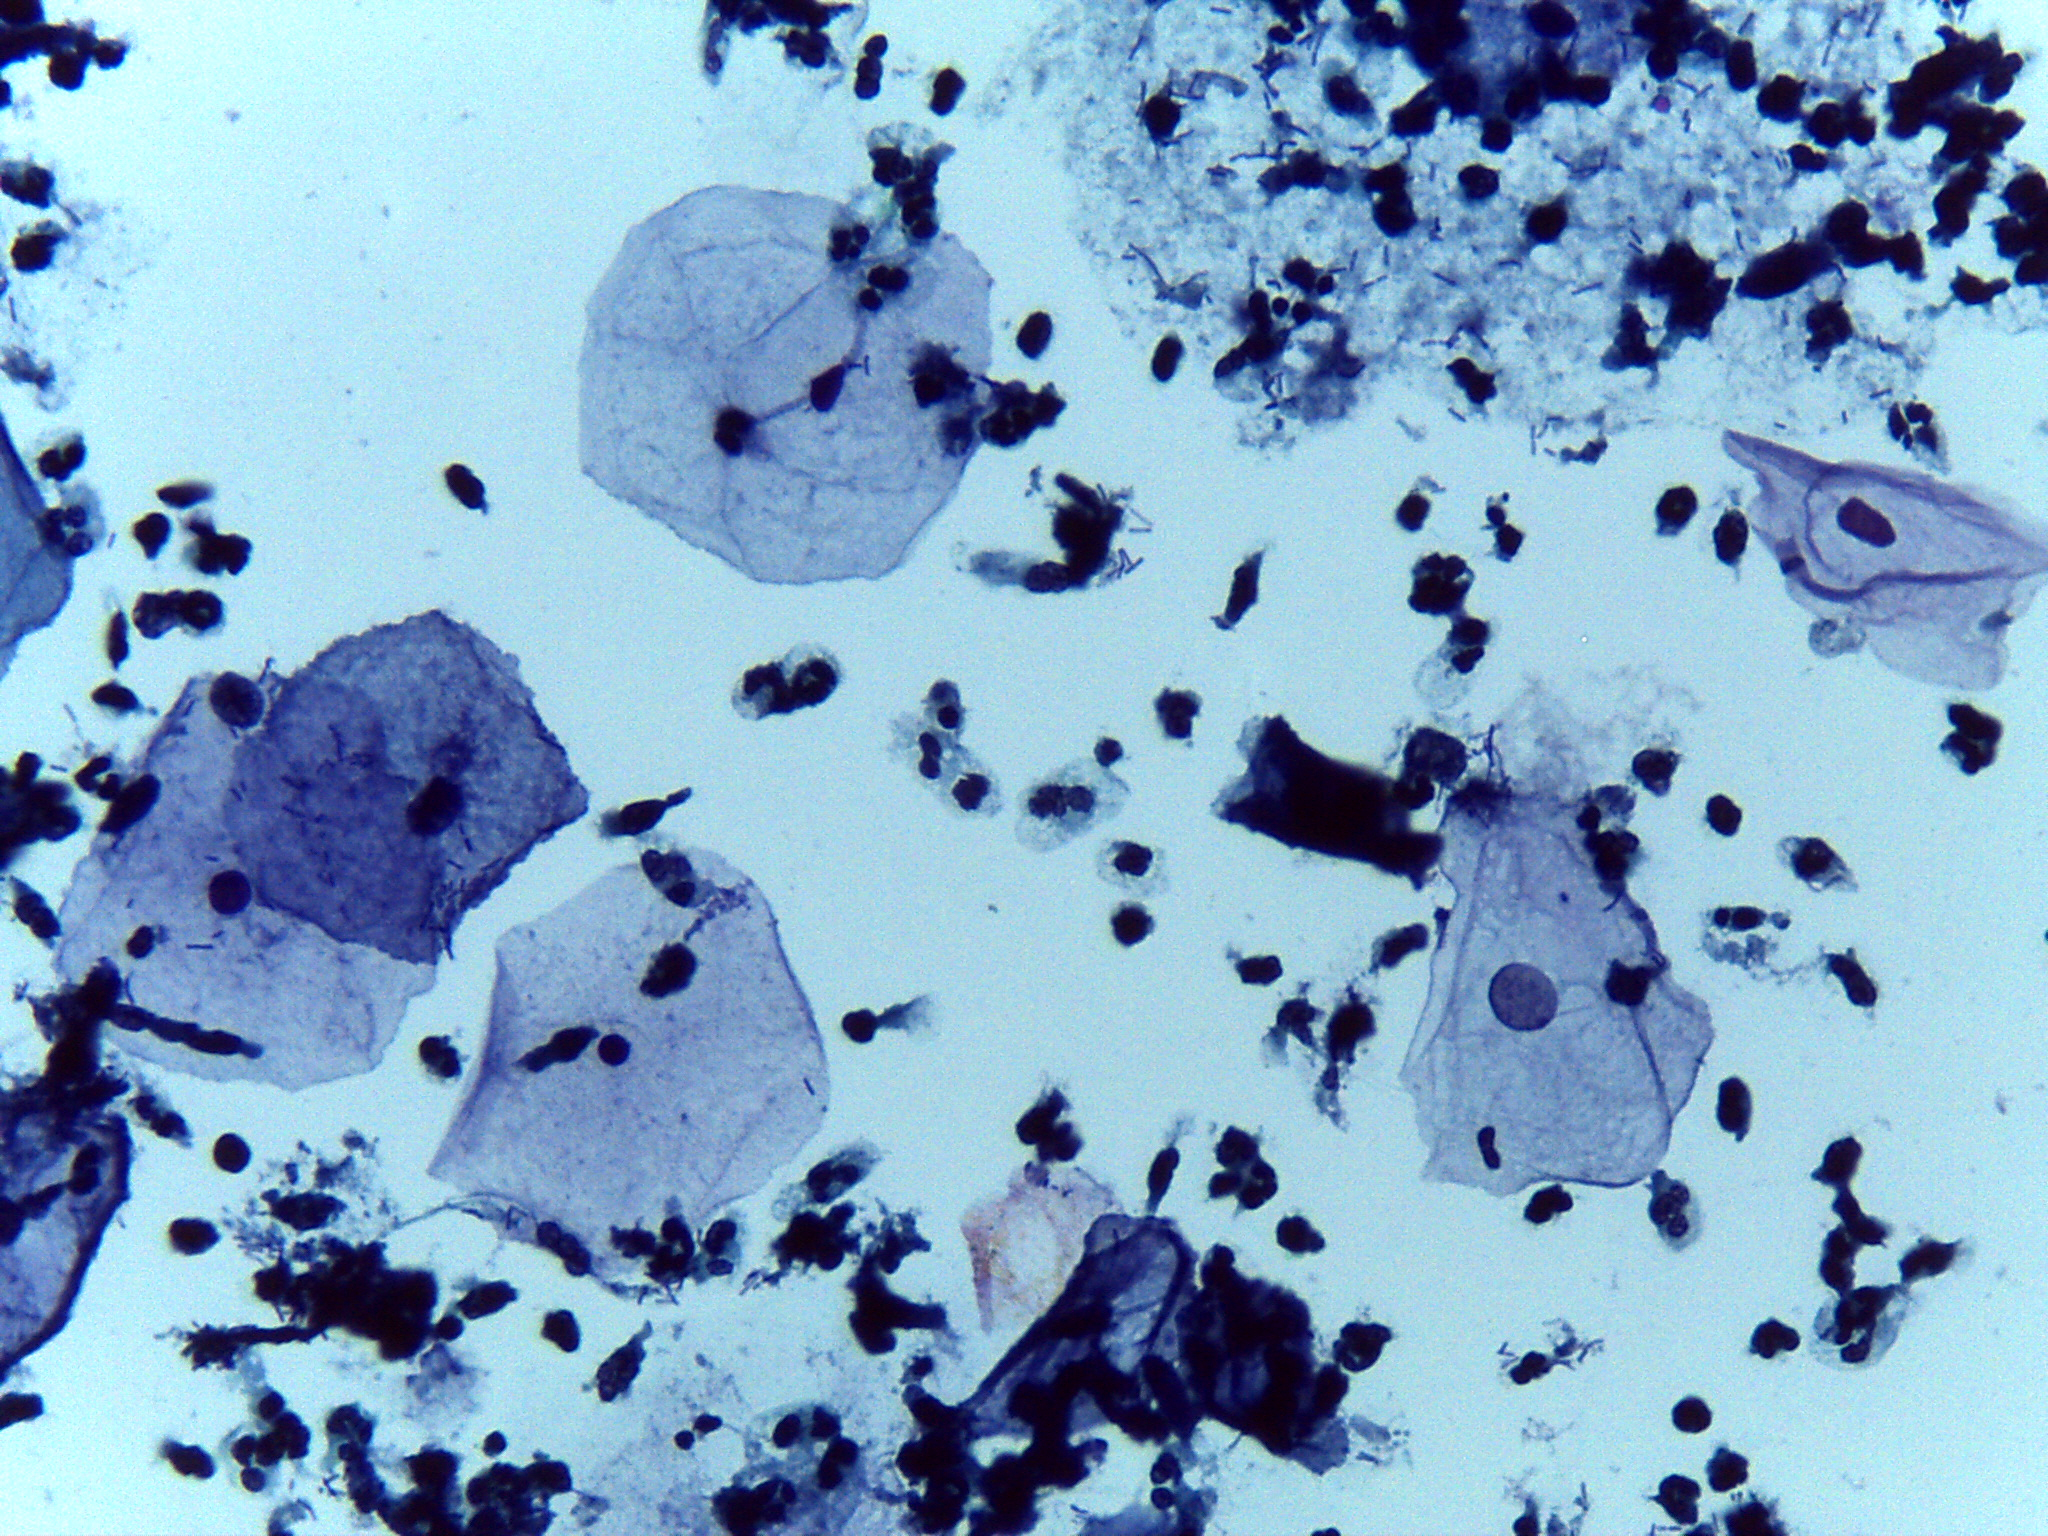

In [ ]:
# Open a random image
idx = random.randint(0, len(labels)-1)
img = Image.open(os.path.join(DATA_DIR, labels['relative_path'][idx]))
# np.array(img).shape
img

## Data class

In [ ]:
class CervData:
    def __init__(
        self, data_dir, df, preprocessor, label2ind, shuffle=False,
        random_seed=None, device='cuda'
    ):
        self.df = df
        self.data_dir = data_dir
        self.num_examples = len(self.df)
        if shuffle:
            self.shuffle(random_seed=random_seed)
        self.label2ind = label2ind
        self.ind2label = {v: k for k, v in label2ind.items()}
        self.num_labels = len(self.label2ind)
        self.preprocessor = preprocessor
        self.device = device
        
    def get_batch(self, s_idx, e_idx, return_labels=True):
        input_dict = self.get_batch_images(s_idx, e_idx)
        if return_labels:
            input_dict['targets'] = self.get_batch_labels(s_idx, e_idx)
        return input_dict
        
    def get_batch_images(self, s_idx, e_idx):
        batch_image_paths = [
            os.path.join(self.data_dir, fn) for fn in self.df['relative_path'][s_idx:e_idx]
        ]
        batch_images = [Image.open(fn) for fn in batch_image_paths]
        batch_images = [self.preprocessor(img).unsqueeze(0) for img in batch_images]
        batch_images = torch.cat(batch_images)
        batch_images = batch_images.to(self.device)
        return {'x': batch_images}
    
    def get_batch_labels(self, s_idx, e_idx):
        batch_labels = self.df['label'][s_idx:e_idx]
        batch_labels_arr = torch.zeros(
            (len(batch_labels), self.num_labels),
            device=self.device
        )
        for i, label in enumerate(batch_labels):
            batch_labels_arr[i, self.label2ind[label]] = 1
        return batch_labels_arr

    def shuffle(self, random_seed=None):
        self.df = self.df.sample(frac=1, replace=False, random_state=random_seed).copy()

## Base model

In [ ]:
if BASE_MODEL_SIZE == 'small':
    from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

    weights = EfficientNet_V2_S_Weights.DEFAULT
    base_model = efficientnet_v2_s(weights=weights)
    base_model = base_model.to("cuda")
elif BASE_MODEL_SIZE == 'medium':
    from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

    weights = EfficientNet_V2_M_Weights.DEFAULT
    base_model = efficientnet_v2_m(weights=weights)
    base_model = base_model.to("cuda")
else:
    raise NotImplementedError("BASE_MODEL_SIZE must be 'small' or 'medium'")

In [ ]:
preprocess = weights.transforms()

## Prepare the data to train the ML model

We shuffle the file labels file and then create train, validation and test splits.

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))
label2ind = {
    label: i for i, label in enumerate(df['label'].drop_duplicates())
}
df = df.sample(
    frac=1, replace=False, random_state=RANDOM_SEED
).copy()

df_train, df_test = train_test_split(df, train_size=0.8, random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=RANDOM_SEED)

print(f"Train size:      {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size:       {len(df_test)}")

Train size:      615
Validation size: 154
Test size:       193


**See below the usage of the data generator class:**

In [ ]:
train_data = CervData(
    data_dir=DATA_DIR,
    df=df_train,
    label2ind=label2ind,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess
)

val_data = CervData(
    data_dir=DATA_DIR,
    df=df_val,
    label2ind=label2ind,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess
)

test_data = CervData(
    data_dir=DATA_DIR,
    df=df_test,
    label2ind=label2ind,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess
)

# Construct our classifier

In [ ]:
from torch import nn


class CervEffNet(nn.Module):
    def __init__(self, base_model, num_classes, freeze_top_n=0):
        super(CervEffNet, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(
                in_features=1280,
                out_features=num_classes,
                bias=True
            )
        )
        
        if freeze_top_n > 0:
            self.freeze_top(freeze_top_n)
        
        self.softmax = nn.Softmax(dim=1)
        self.loss_func = nn.CrossEntropyLoss()
        
    def freeze_top(self, top_n=1):
        for param in self.features[:top_n].parameters():
            param.requires_grad = False
            
    def forward(self, x, targets=None):
        features = self.avgpool(
            self.features(x)
        )
        out = self.classifier(features.squeeze())
        
        outputs = {
            'pooled_output': out,
            'probabilities': self.softmax(out)
        }
        
        if targets is not None:
            outputs['loss'] = self.loss_func(out, targets)
            
        return outputs

The EfficientNet base model has a total of 8 layers before the classification layers. We freeze the first six, i.e. we make only the last two feature layers trainable.

In [ ]:
model = CervEffNet(base_model, num_classes=4, freeze_top_n=6)
model = model.to("cuda")

# Train the model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from tqdm.notebook import tqdm

def pytorch_training_loop(
    model, optimizer, train_data, val_data, num_labels,
    start_epoch, total_epochs, batch_size, model_save_path,
    scheduler=None, best_val_score=0, patience=5, shuffle_data=False
):

    epoch = start_epoch
    n_train = train_data.num_examples
   
    non_improvement = 0
    
    for epoch in range(epoch, total_epochs):
            
        epoch_loss = 0
        epoch_p = 0
        epoch_r = 0
        epoch_f = 0
        epoch_test_steps = 0

        print("Training epoch {}".format(epoch+1))
        if non_improvement > 0:
            print("Early stopping {}/{}".format(non_improvement, patience))

        model.train()
        
        if shuffle_data:
            train_data.shuffle(random_seed=epoch)

        pbar = tqdm(range(0, n_train, batch_size), unit="steps", desc="Training")

        # Training loop
        for i in pbar:
            end_ix = min(i+batch_size, n_train)
            start_ix = end_ix - batch_size
            step_count = int(start_ix/batch_size)

            input_dict = train_data.get_batch(start_ix, end_ix, return_labels=True)
            
            optimizer.zero_grad()
            
            model_output = model(**input_dict)
            loss = model_output['loss']
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            if step_count % 10 == 0:
                probabilities = model_output[
                    'probabilities'].detach().cpu().numpy()
                predictions = (probabilities > 0.5).astype(np.int32)
                p, r, f, _ = precision_recall_fscore_support(
                    input_dict['targets'].cpu().detach().numpy(),
                    predictions,
                    average='weighted',
                    zero_division=0
                )
                epoch_test_steps += 1
                epoch_loss += loss.detach().item()
                epoch_p += p
                epoch_r += r
                epoch_f += f
                pbar.set_postfix_str(
                    "Loss {:.4f}, Precision {:.4f}, Recall {:.4f}, F1 {:.4f}".format(
                        epoch_loss/epoch_test_steps,
                        epoch_p/epoch_test_steps,
                        epoch_r/epoch_test_steps,
                        epoch_f/epoch_test_steps
                    )
                )

        # Validation loop
        val_probs, val_targs = pytorch_testing_loop(
            model, val_data, num_labels, batch_size
        )
        val_predictions = (val_probs > 0.5).astype(np.int32)
        val_p, val_r, val_f, _ = precision_recall_fscore_support(
            val_targs,
            val_predictions,
            average='weighted',
            zero_division=0
        )
        if val_f >= best_val_score:
            best_val_score = val_f
            non_improvement = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            non_improvement += 1
        print('Precision (val): {:.4f}, Recall (val): {:.4f}, F1 (val): {:.4f} | Best validation F1: {:.4f}\n'.format(
            val_p, val_r, val_f, best_val_score)
        )
        
        if non_improvement == patience:
            return best_val_score
        
        if scheduler is not None:
            scheduler.step(val_f)
        
    return best_val_score


def pytorch_testing_loop(model, test_data, num_labels, batch_size):

    n_test = test_data.num_examples
    
    # Testing loop
    test_probs = np.zeros((n_test, num_labels))
    test_targs = np.zeros((n_test, num_labels))
    model.eval()

    pbar = tqdm(range(0, n_test, batch_size), unit="steps", desc="Testing")
    for i in pbar:
        end_ix = min(i+batch_size, n_test)
        start_ix = end_ix - batch_size

        input_dict = test_data.get_batch(start_ix, end_ix, return_labels=True)
        
        with torch.no_grad():
            model_output = model(**input_dict)
        
        _probs = model_output['probabilities'].detach().cpu().numpy()
        test_probs[start_ix:end_ix, :] = _probs
        test_targs[start_ix:end_ix, :] = input_dict['targets'].detach().cpu().numpy()

    return test_probs, test_targs

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    weight_decay=0,
    lr=3e-04
)

In [ ]:
if not os.path.exists('saved_models'):
    os.mkdir('./saved_models')

In [ ]:
val_score = pytorch_training_loop(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    val_data=val_data,
    num_labels=train_data.num_labels,
    start_epoch=0,
    total_epochs=30,
    batch_size=8,
    model_save_path='saved_models/model.pt',
    scheduler=None,
    best_val_score=0,
    patience=5,
    shuffle_data=False
)

Training epoch 1


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.8571, Recall (val): 0.7013, F1 (val): 0.6935 | Best validation F1: 0.6935

Training epoch 2


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9372, Recall (val): 0.8896, F1 (val): 0.9052 | Best validation F1: 0.9052

Training epoch 3


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9736, Recall (val): 0.9610, F1 (val): 0.9671 | Best validation F1: 0.9671

Training epoch 4


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9612, Recall (val): 0.9416, F1 (val): 0.9344 | Best validation F1: 0.9671

Training epoch 5
Early stopping 1/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9600, Recall (val): 0.9481, F1 (val): 0.9471 | Best validation F1: 0.9671

Training epoch 6
Early stopping 2/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9870, Recall (val): 0.9870, F1 (val): 0.9870 | Best validation F1: 0.9870

Training epoch 7


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9469, Recall (val): 0.8896, F1 (val): 0.8913 | Best validation F1: 0.9870

Training epoch 8
Early stopping 1/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9770, Recall (val): 0.9610, F1 (val): 0.9625 | Best validation F1: 0.9870

Training epoch 9
Early stopping 2/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9720, Recall (val): 0.9675, F1 (val): 0.9649 | Best validation F1: 0.9870

Training epoch 10
Early stopping 3/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9878, Recall (val): 0.9870, F1 (val): 0.9867 | Best validation F1: 0.9870

Training epoch 11
Early stopping 4/5


Training:   0%|          | 0/77 [00:00<?, ?steps/s]

Testing:   0%|          | 0/20 [00:00<?, ?steps/s]

Precision (val): 0.9770, Recall (val): 0.9740, F1 (val): 0.9725 | Best validation F1: 0.9870



In [ ]:
model.load_state_dict(torch.load('saved_models/model.pt'))

test_probs, test_targs = pytorch_testing_loop(
    model=model,
    test_data=test_data,
    num_labels=test_data.num_labels,
    batch_size=8
)
test_predictions = (test_probs > 0.5).astype(np.int32)

test_p, test_r, test_f, _ = precision_recall_fscore_support(
    test_targs,
    test_predictions,
    average='weighted',
    zero_division=0
)
print(f"Precision (test)     {test_p:.4f}")
print(f"Recall (test)        {test_r:.4f}")
print(f"F1 (weighted) (test) {test_f:.4f}")

pred_index = np.argmax(test_predictions, axis=1)
target_index = np.argmax(test_targs, axis=1)
correct = [p == y for p, y in zip(pred_index, target_index)]
print(f"Test accuracy:       {np.mean(correct)*100:.2f}%")

Testing:   0%|          | 0/25 [00:00<?, ?steps/s]

Precision (test)     0.9798
Recall (test)        0.9793
F1 (weighted) (test) 0.9795
Test accuracy:       97.93%
